In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [2]:
df = df = pd.read_csv('data/spotify1921-2020.csv', converters={'artists': literal_eval})

In [3]:
# we mark our treatment as the "explicit" column and our effect as the popularity column
# (treatment is binary and popularity ranges from 0 to 100)
df = df.rename(columns={'explicit': 'treatment', 'popularity': 'effect'})

In [4]:
# we remove the release_date column as its format is not consistent across all records
# some records have the complete date, some have the year only - we take the year only
df = df.drop(columns=['release_date'])
# we remove id, song name and artist name as they are not useful for our analysis
df = df.drop(columns=['id', 'name'])

In [5]:
# to extract information from the artists column, without having to add a one-hot encoding for each artist (4000+)
# we will instead, try to extract a "popularity" and "explicitness" for each song based on the artists that are associated with it
# we will do this by taking the average popularity and explicit of all the previous songs from the artists that are associated with it
# we take only the first artist as the main artist
df['artists'] = df['artists'].apply(lambda x: x[0])
df = df.sort_values(by=['artists', 'year'])
# 2234 is the max amount of songs by an artist
df['previous_artist_explicitness'] = df.groupby('artists')['treatment'].transform(
    lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df['previous_artist_popularity'] = df.groupby('artists')['effect'].transform(
    lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df = df.drop(columns=['artists'])

In [6]:
# reorder all the columns
df = pd.concat([df.loc[:, ~df.columns.isin(['treatment', 'effect'])], df.loc[:, ['treatment', 'effect']]], axis=1)

# Data Analysis and Statistics

In [7]:
df.describe(percentiles=[]).iloc[1:]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,previous_artist_explicitness,previous_artist_popularity,treatment,effect
mean,0.493214,0.538150,2.314062e+05,0.488593,0.161937,5.200519,0.206690,-11.370289,0.708556,0.094058,116.948017,0.532095,1977.223231,0.074552,25.331268,0.084863,31.556610
std,0.376627,0.175346,1.213219e+05,0.267390,0.309329,3.515257,0.176796,5.666765,0.454429,0.149937,30.726937,0.262408,25.593168,0.241215,20.481236,0.278679,21.582614
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,1921.000000,0.000000,0.000000,0.000000,0.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000204,5.000000,0.135000,-10.474000,1.000000,0.045000,114.778000,0.544000,1978.000000,0.000000,27.875000,0.000000,33.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,0.969000,244.091000,1.000000,2020.000000,1.000000,96.000000,1.000000,100.000000


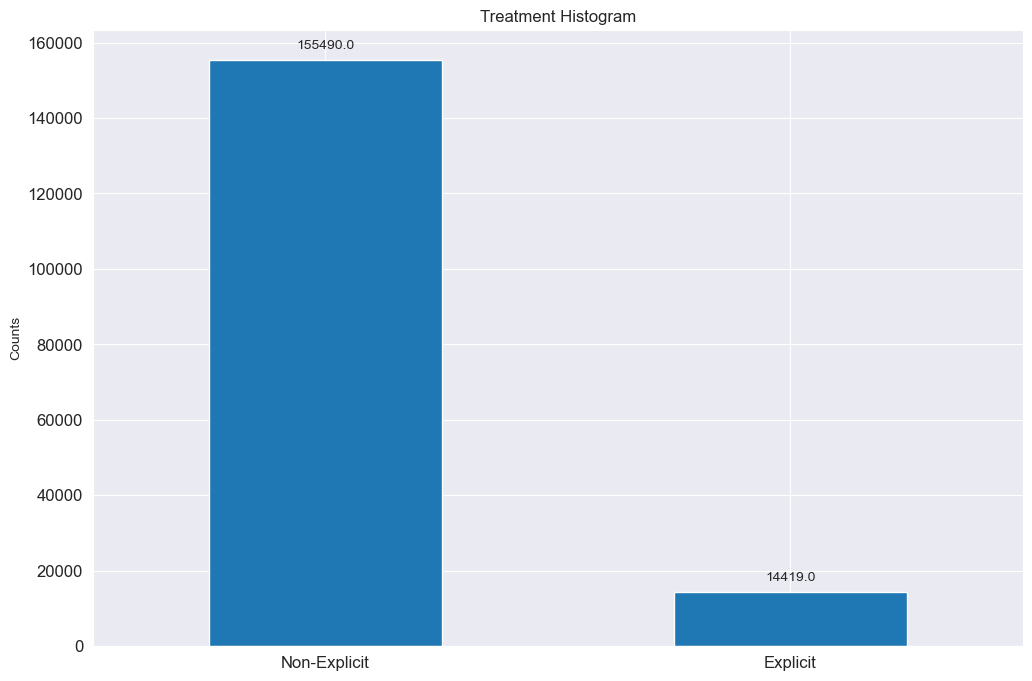

In [8]:
import matplotlib.pyplot as plt

# plot histogram of treatment column
_, ax = plt.subplots(figsize=(12, 8))
df['treatment'].value_counts().plot(kind='bar', title='Treatment Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Non-Explicit', 'Explicit'])
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, 10), textcoords='offset points')
plt.ylabel('Counts')
plt.show()

C:\Users\naorh\AppData\Local\Temp\ipykernel_23352\3681809650.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


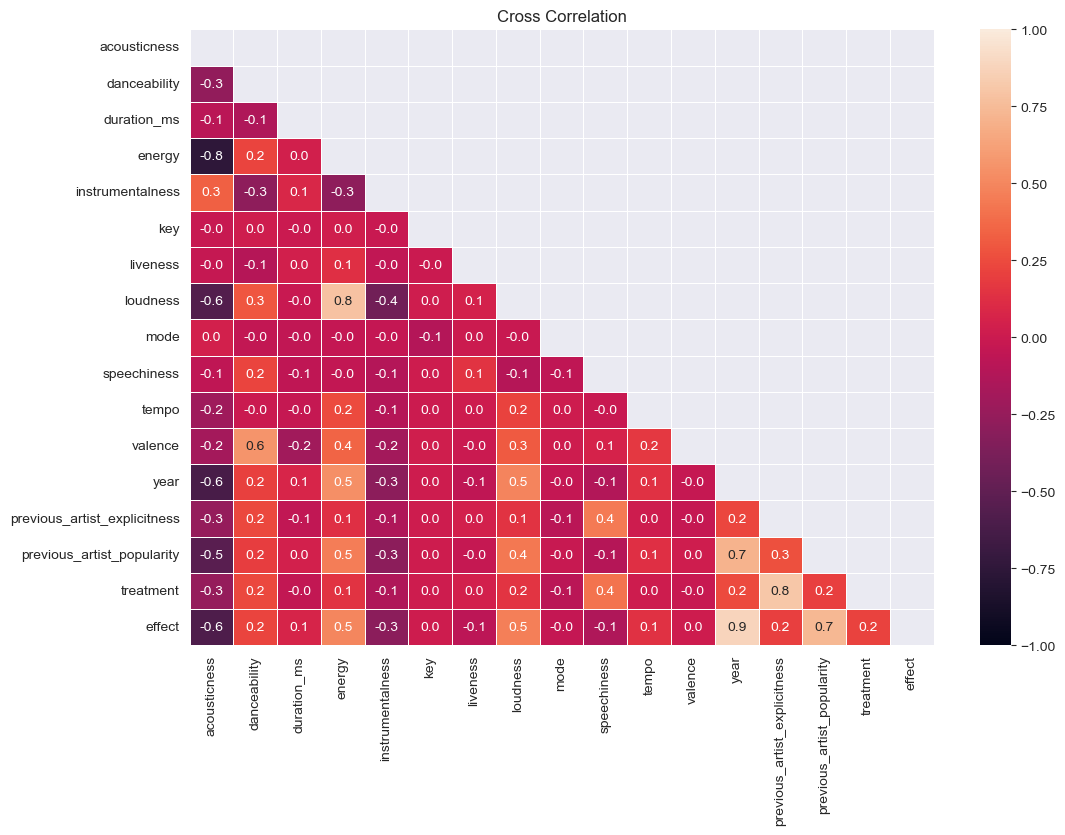

In [9]:
# correlation
# cross correlation between our features, the treatment and the effect
# plot as matplotlib heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(figsize=(12, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f')
ax.title.set_text('Cross Correlation')
plt.show()

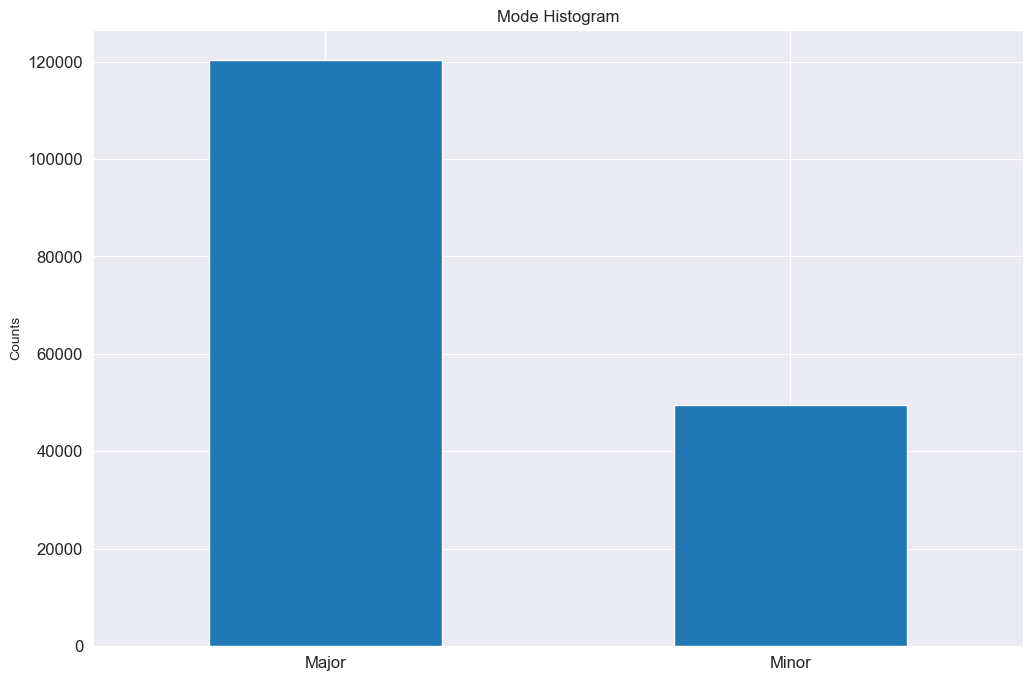

In [10]:
# plot histogram of mode column
_, ax = plt.subplots(figsize=(14, 10))
df['mode'].value_counts().plot(kind='bar', title='Mode Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Major', 'Minor'])
plt.ylabel('Counts')
plt.show()

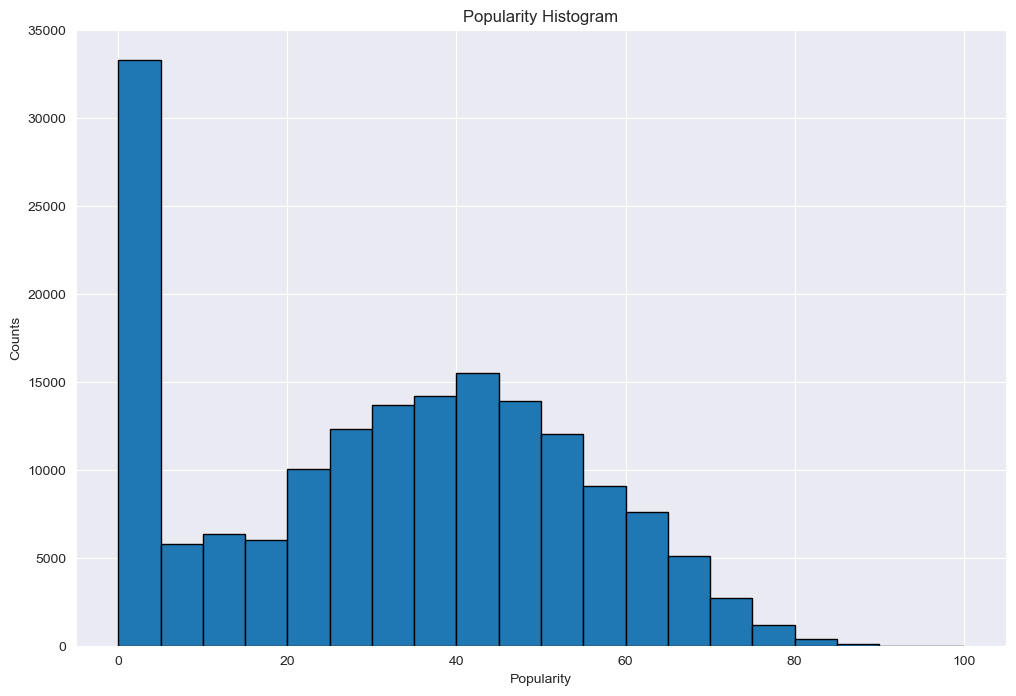

In [11]:
# plot histogram of effect column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(0, 101, 5))
plt.hist(df.effect.values, bins=bins, edgecolor="k")
ax.set_xlabel('Popularity')
plt.xticks(rotation=0)
ax.title.set_text('Popularity Histogram')
plt.ylabel('Counts')
plt.show()

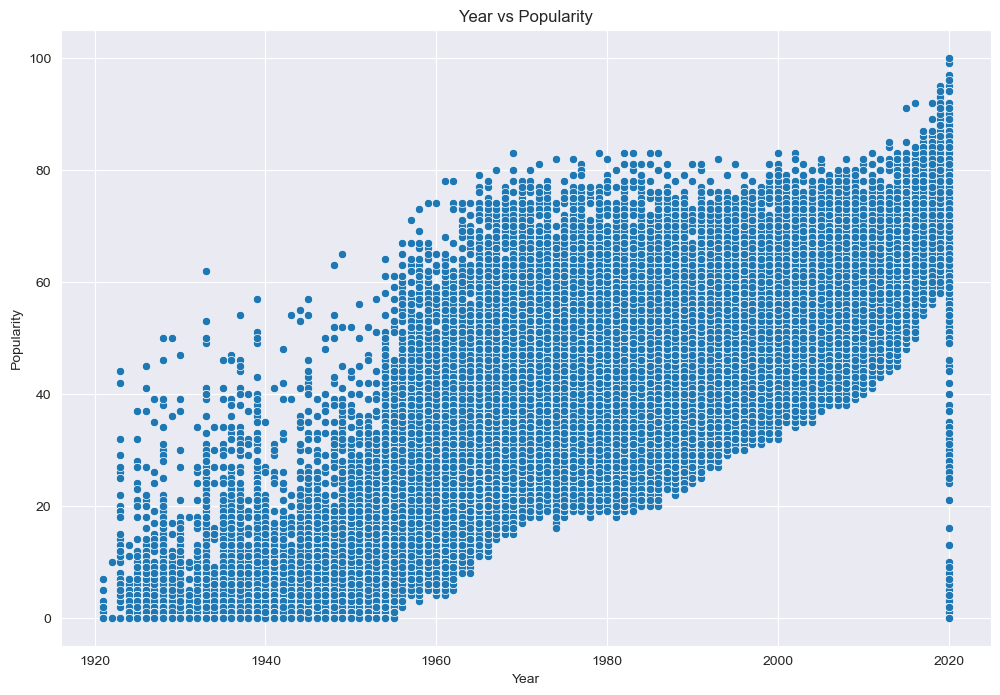

In [12]:
#  plot of year vs effect
_, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='year', y='effect', data=df, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Popularity')
ax.title.set_text('Year vs Popularity')
plt.show()

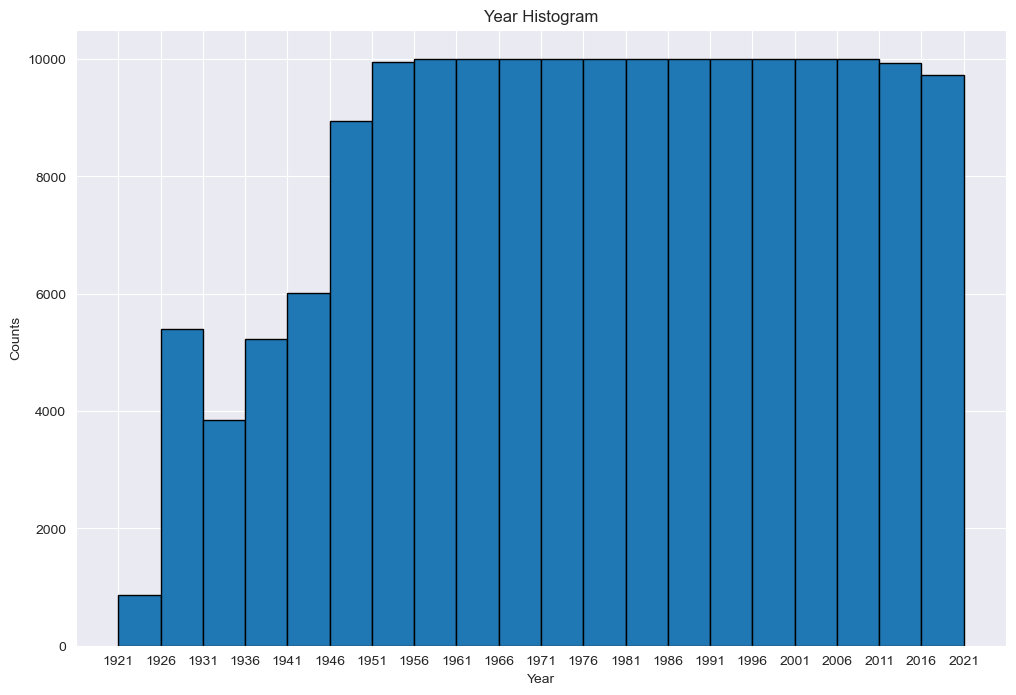

In [13]:
# plot histogram of year column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(1921, 2022, 5))
plt.hist(df.year.values, bins=bins, edgecolor="k")
plt.xticks(bins)
ax.title.set_text('Year Histogram')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.show()

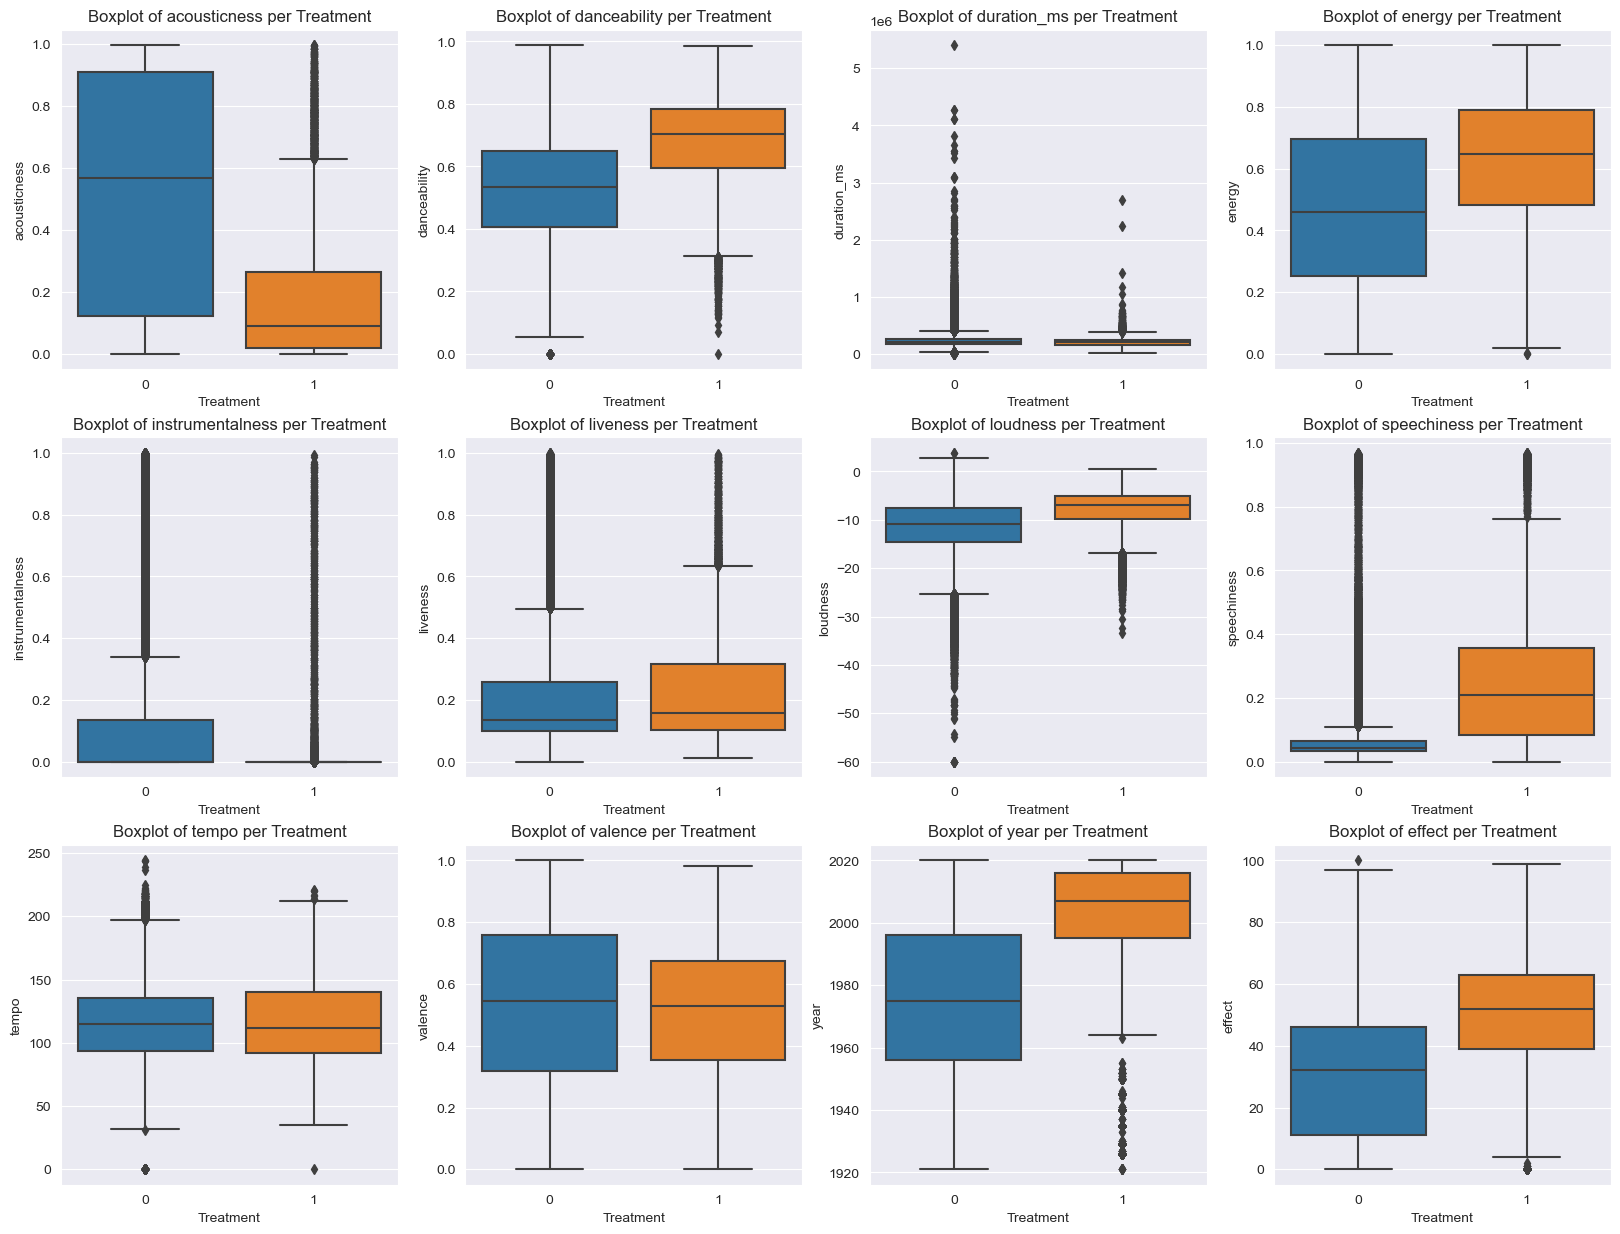

In [14]:
# plot a boxplot for each feature in both groups of treatment
_, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, col in enumerate(df.columns[~df.columns.isin(
        ['treatment', 'previous_artist_popularity', 'previous_artist_explicitness', 'mode', 'propensity_score',
         'key'])]):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x='treatment', y=col, data=df, ax=ax)
    ax.set_xlabel('Treatment')
    ax.set_ylabel(col)

    ax.title.set_text(f'Boxplot of {col} per Treatment')
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def calculate_propensity_score(df):
    scaled = StandardScaler().fit_transform(df.drop(['effect', 'treatment'], axis=1))
    LR = LogisticRegression(random_state=0)
    LR.fit(scaled, df['treatment'])
    prop = LR.predict_proba(scaled)[:, 1]

    return prop


# calculate propensity score
df['propensity_score'] = calculate_propensity_score(df)

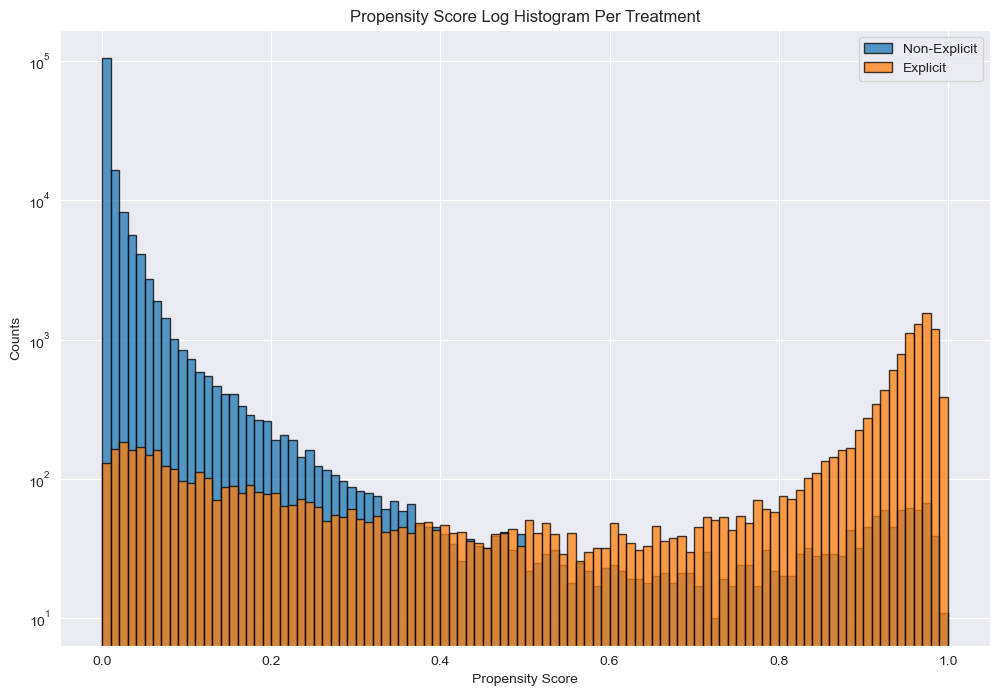

In [17]:
# plot propensity score histogram stacked by treatment, log scale
import numpy as np

_, ax = plt.subplots(figsize=(12, 8))
bins = np.arange(0, 1.01, 0.01)
plt.hist(df.propensity_score[df.treatment == 0].values, bins=bins, edgecolor="k", log=True, alpha=0.75,
         label='Non-Explicit')
plt.hist(df.propensity_score[df.treatment == 1].values, bins=bins, edgecolor="k", log=True, alpha=0.75,
         label='Explicit')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Counts')
ax.title.set_text('Propensity Score Log Histogram Per Treatment')
ax.legend()
plt.show()

In [18]:
df.drop('propensity_score', axis=1)
df.to_csv('data/final_data.csv', index=False)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import gc


class ATE_calculator:
    def __init__(self, df):
        self.df = df
        # split to train and test for learners
        self.train, self.test = train_test_split(self.df, test_size=0.2, random_state=42)
        # separate the data into treated and not treated
        self.df_T0 = self.df[self.df['treatment'] == 0]
        self.df_T1 = self.df[self.df['treatment'] == 1]
        # split to train and test
        self.train_T0, self.test_T0 = self.train[self.train['treatment'] == 0], self.test[self.test['treatment'] == 0]
        self.train_T1, self.test_T1 = self.train[self.train['treatment'] == 1], self.test[self.test['treatment'] == 1]

        self.propensity = self.calculate_propensity_score()

    def calculate_propensity_score(self):
        scaled = StandardScaler().fit_transform(self.df.drop(['effect', 'treatment'], axis=1))
        LR = LogisticRegression(random_state=0)
        LR.fit(scaled, self.df['treatment'])
        prop = LR.predict_proba(scaled)[:, 1]

        return prop

    def calculate_IPW_ATE(self):
        def ATE_IPW_formula(y, t, e):
            left = sum(t * y / e)
            right = sum((1 - t) * y / (1 - e))
            return (left - right) / len(y)

        # calculate the IPW ATT by the function we built
        ATE_IPW = ATE_IPW_formula(self.df['effect'], self.df['treatment'], self.propensity)
        # add results to the dictionary
        return ATE_IPW

    def calculate_S_Learner_ATE(self):
        # learn a linear function with all data
        S_learner = sm.OLS(self.train['effect'], self.train.drop('effect', axis=1)).fit()

        def predict_for_df(df_for_predict):
            # pred only on treated data
            dummy_treated_0 = df_for_predict.drop(['effect'], axis=1)
            dummy_treated_0['treatment'] = 0
            dummy_treated_1 = df_for_predict.drop(['effect'], axis=1)
            dummy_treated_1['treatment'] = 1
            y_pred_0 = S_learner.predict(dummy_treated_0)
            y_pred_1 = S_learner.predict(dummy_treated_1)

            return np.mean(y_pred_1 - y_pred_0)

        # add results to the dictionary
        ATE_S_learner_train = predict_for_df(self.train)
        ATE_S_learner_test = predict_for_df(self.test)

        train_MSE = mean_squared_error(self.train['effect'], S_learner.predict(self.train.drop('effect', axis=1)))
        test_MSE = mean_squared_error(self.test['effect'], S_learner.predict(self.test.drop('effect', axis=1)))

        return ATE_S_learner_train, ATE_S_learner_test, train_MSE, test_MSE

    def calculate_T_Learner_ATE(self):
        # learn a linear function for the not treated data only
        T0_learner = sm.OLS(self.train_T0['effect'], self.train_T0.drop(['treatment', 'effect'], axis=1)).fit()
        # learn a linear function for the treated data only
        T1_learner = sm.OLS(self.train_T1['effect'], self.train_T1.drop(['treatment', 'effect'], axis=1)).fit()

        def predict_for_df(df_for_predict):
            # pred only on treated data using both models
            y_pred_0 = T0_learner.predict(df_for_predict.drop(['treatment', 'effect'], axis=1))
            y_pred_1 = T1_learner.predict(df_for_predict.drop(['treatment', 'effect'], axis=1))

            return np.mean(y_pred_1 - y_pred_0)

            # add results to the dictionary

        ATE_T_learner_train = predict_for_df(self.train)
        ATE_T_learner_test = predict_for_df(self.test)

        train_T0_MSE = mean_squared_error(self.train_T0['effect'], T0_learner.predict(self.train_T0.drop(['treatment', 'effect'], axis=1)))
        train_T1_MSE = mean_squared_error(self.train_T1['effect'], T1_learner.predict(self.train_T1.drop(['treatment', 'effect'], axis=1)))
        test_T0_MSE = mean_squared_error(self.test_T0['effect'], T0_learner.predict(self.test_T0.drop(['treatment', 'effect'], axis=1)))
        test_T1_MSE = mean_squared_error(self.test_T1['effect'], T1_learner.predict(self.test_T1.drop(['treatment', 'effect'], axis=1)))

        return ATE_T_learner_train, ATE_T_learner_test, train_T0_MSE, train_T1_MSE, test_T0_MSE, test_T1_MSE

    def calculate_matching_ATE(self):
        knn_0 = KNeighborsRegressor(n_neighbors=1)
        knn_0.fit(self.df_T0.drop('effect', axis=1), self.df_T0['effect'])
        ATE_matching_1 = (self.df_T1['effect'] - pd.Series(knn_0.predict(self.df_T1.drop('effect', axis=1)),
                                                           index=self.df_T1.index)).sum()

        del knn_0
        gc.collect()

        knn_1 = KNeighborsRegressor(n_neighbors=1)
        knn_1.fit(self.df_T1.drop('effect', axis=1), self.df_T1['effect'])
        ATE_matching_0 = (
                    pd.Series(knn_1.predict(self.df_T0.drop('effect', axis=1)), index=self.df_T0.index) - self.df_T0[
                'effect']).sum()

        del knn_1
        gc.collect()

        # add results to the dictionary
        ATE_matching = (ATE_matching_1 + ATE_matching_0) / len(self.df)

        return ATE_matching

In [47]:
# Without bootstrap
ate = ATE_calculator(df)
print(ate.calculate_IPW_ATE())
print(ate.calculate_S_Learner_ATE())
print(ate.calculate_T_Learner_ATE())
print(ate.calculate_matching_ATE())

0.40922482131902177
(2.9010879285014632, 2.9010879284952034, 155.6442040151111, 156.72441790895863)
(17.10572236958772, 17.1606484364339, 156.01606744686302, 83.86577230346042, 157.975182892171, 87.12764099782063)
13.61591793254036


In [20]:
from scipy import stats

def CI(arr, alpha=0.05):
    Z = stats.norm.ppf(q=1 - alpha / 2)
    return [np.mean(arr) - Z * np.std(arr), np.mean(arr) + Z * np.std(arr)]

In [49]:
from tqdm import tqdm
# With bootstrap and balance
IPW_arr, SL_arr_train, SL_arr_test, SL_arr_train_MSE, SL_arr_test_MSE, TL_arr_train, TL_arr_test, TL_arr_T0_train_MSE, TL_arr_T1_train_MSE, TL_arr_T0_test_MSE, TL_arr_T1_test_MSE, matching_arr = [], [], [], [], [], [], [], [], [], [], [], []
n = len(df[df['treatment'] == 1])
for b in tqdm(range(250)):
    bootstrap_Exp = df[df['treatment'] == 1].sample(n, replace=True)
    bootstrap_NonExp = df[df['treatment'] == 0].sample(n, replace=True)
    cur_df = pd.concat([bootstrap_Exp, bootstrap_NonExp])
    ate = ATE_calculator(cur_df)
    IPW_arr.append(ate.calculate_IPW_ATE())
    SL_results = ate.calculate_S_Learner_ATE()
    SL_arr_train.append(SL_results[0])
    SL_arr_test.append(SL_results[1])
    SL_arr_train_MSE.append(SL_results[2])
    SL_arr_test_MSE.append(SL_results[3])
    TL_results = ate.calculate_T_Learner_ATE()
    TL_arr_train.append(TL_results[0])
    TL_arr_test.append(TL_results[1])
    TL_arr_T0_train_MSE.append(TL_results[2])
    TL_arr_T1_train_MSE.append(TL_results[3])
    TL_arr_T0_test_MSE.append(TL_results[4])
    TL_arr_T1_test_MSE.append(TL_results[5])
    matching_arr.append(ate.calculate_matching_ATE())

100%|██████████| 250/250 [18:30<00:00,  4.44s/it]


In [50]:
print(np.mean(IPW_arr), np.mean(SL_arr_train), np.mean(SL_arr_test), np.mean(SL_arr_train_MSE), np.mean(SL_arr_test_MSE), np.mean(TL_arr_train), np.mean(TL_arr_test), np.mean(TL_arr_T0_train_MSE), np.mean(TL_arr_T1_train_MSE), np.mean(TL_arr_T0_test_MSE), np.mean(TL_arr_T1_test_MSE), np.mean(matching_arr), sep='\n')

-26.418548520014237
9.893482519143493
9.893482519143458
135.08613040333933
135.03853463723235
6.508355101520576
6.456751138639081
156.25964026432445
84.3422643382152
156.50555078904225
84.54433351812435
11.816676745960192


In [51]:
IPW_CI = CI(IPW_arr)
SL_CI_train = CI(SL_arr_train)
SL_CI_test = CI(SL_arr_test)
SL_CI_train_MSE = CI(SL_arr_train_MSE)
SL_CI_test_MSE = CI(SL_arr_test_MSE)
TL_CI_train = CI(TL_arr_train)
TL_CI_test = CI(TL_arr_test)
TL_CI_T0_train_MSE = CI(TL_arr_T0_train_MSE)
TL_CI_T1_train_MSE = CI(TL_arr_T1_train_MSE)
TL_CI_T0_test_MSE = CI(TL_arr_T0_test_MSE)
TL_CI_T1_test_MSE = CI(TL_arr_T1_test_MSE)
Match_CI = CI(matching_arr)
print(IPW_CI, SL_CI_train, SL_CI_test, TL_CI_train, TL_CI_test, Match_CI, sep='\n')

[-47.06579261999269, -5.771304420035783]
[9.289517972480969, 10.497447065806018]
[9.289517972480754, 10.497447065806162]
[5.166365480365098, 7.850344722676054]
[5.105550762471712, 7.807951514806451]
[11.359447280077157, 12.273906211843228]


In [ ]:
from tqdm import tqdm
# With bootstrap and without balance
IPW_arr, SL_arr_train, SL_arr_test, SL_arr_train_MSE, SL_arr_test_MSE, TL_arr_train, TL_arr_test, TL_arr_T0_train_MSE, TL_arr_T1_train_MSE, TL_arr_T0_test_MSE, TL_arr_T1_test_MSE, matching_arr = [], [], [], [], [], [], [], [], [], [], [], []
n = len(df)
for b in tqdm(range(250)):
    cur_df = df.sample(n, replace=True)
    ate = ATE_calculator(cur_df)
    IPW_arr.append(ate.calculate_IPW_ATE())
    SL_results = ate.calculate_S_Learner_ATE()
    SL_arr_train.append(SL_results[0])
    SL_arr_test.append(SL_results[1])
    SL_arr_train_MSE.append(SL_results[2])
    SL_arr_test_MSE.append(SL_results[3])
    TL_results = ate.calculate_T_Learner_ATE()
    TL_arr_train.append(TL_results[0])
    TL_arr_test.append(TL_results[1])
    TL_arr_T0_train_MSE.append(TL_results[2])
    TL_arr_T1_train_MSE.append(TL_results[3])
    TL_arr_T0_test_MSE.append(TL_results[4])
    TL_arr_T1_test_MSE.append(TL_results[5])
    matching_arr.append(ate.calculate_matching_ATE())

100%|█████████▉| 249/250 [3:02:06<00:43, 43.58s/it]  

In [ ]:
print(np.mean(IPW_arr), np.mean(SL_arr_train), np.mean(SL_arr_test), np.mean(SL_arr_train_MSE), np.mean(SL_arr_test_MSE), np.mean(TL_arr_train), np.mean(TL_arr_test), np.mean(TL_arr_T0_train_MSE), np.mean(TL_arr_T1_train_MSE), np.mean(TL_arr_T0_test_MSE), np.mean(TL_arr_T1_test_MSE), np.mean(matching_arr), sep='\n')

In [ ]:
IPW_CI = CI(IPW_arr)
SL_CI_train = CI(SL_arr_train)
SL_CI_test = CI(SL_arr_test)
SL_CI_train_MSE = CI(SL_arr_train_MSE)
SL_CI_test_MSE = CI(SL_arr_test_MSE)
TL_CI_train = CI(TL_arr_train)
TL_CI_test = CI(TL_arr_test)
TL_CI_T0_train_MSE = CI(TL_arr_T0_train_MSE)
TL_CI_T1_train_MSE = CI(TL_arr_T1_train_MSE)
TL_CI_T0_test_MSE = CI(TL_arr_T0_test_MSE)
TL_CI_T1_test_MSE = CI(TL_arr_T1_test_MSE)
Match_CI = CI(matching_arr)
print(IPW_CI, SL_CI_train, SL_CI_test, TL_CI_train, TL_CI_test, Match_CI, sep='\n')